<a href="https://colab.research.google.com/github/EBUSYGIN/ML-3/blob/main/ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Загрузка данных
train_path = "train.xlsx"
test_path = "test.xlsx"
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

In [41]:
# Преобразование даты в индекс
train_df["dt"] = pd.to_datetime(train_df["dt"])
test_df["dt"] = pd.to_datetime(test_df["dt"])
train_df.set_index("dt", inplace=True)
test_df.set_index("dt", inplace=True)

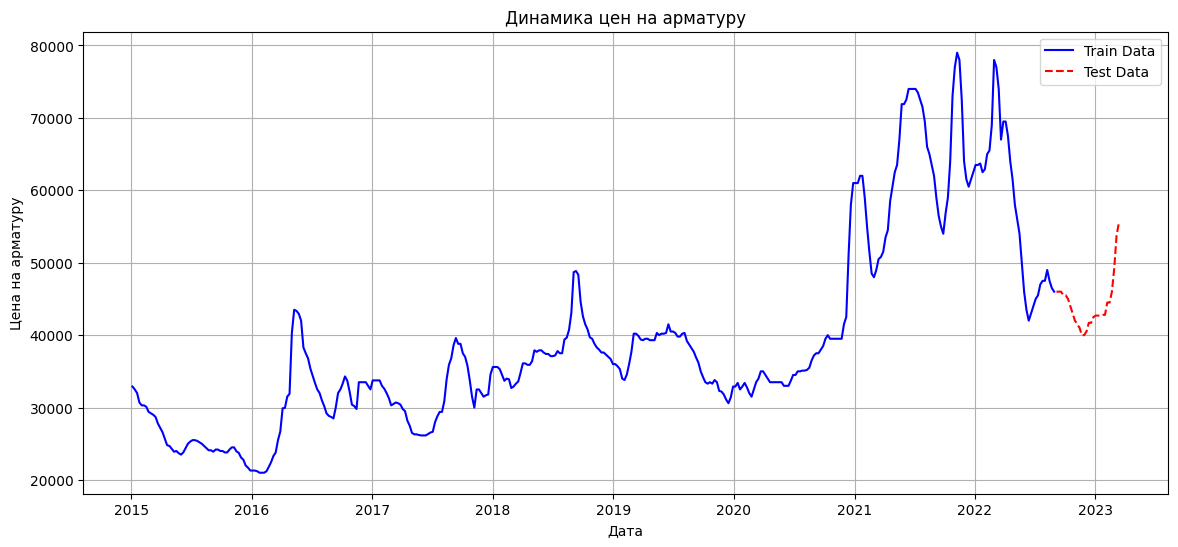

In [42]:
# Визуализация временного ряда
plt.figure(figsize=(14, 6))
plt.plot(train_df.index, train_df["Цена на арматуру"], label="Train Data", color='blue')
plt.plot(test_df.index, test_df["Цена на арматуру"], label="Test Data", color='red', linestyle='dashed')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.legend()
plt.grid()
plt.show()

In [43]:
# Проверка стационарности
adf_test = adfuller(train_df["Цена на арматуру"])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

ADF Statistic: -1.9258699893713456, p-value: 0.31999061025699155


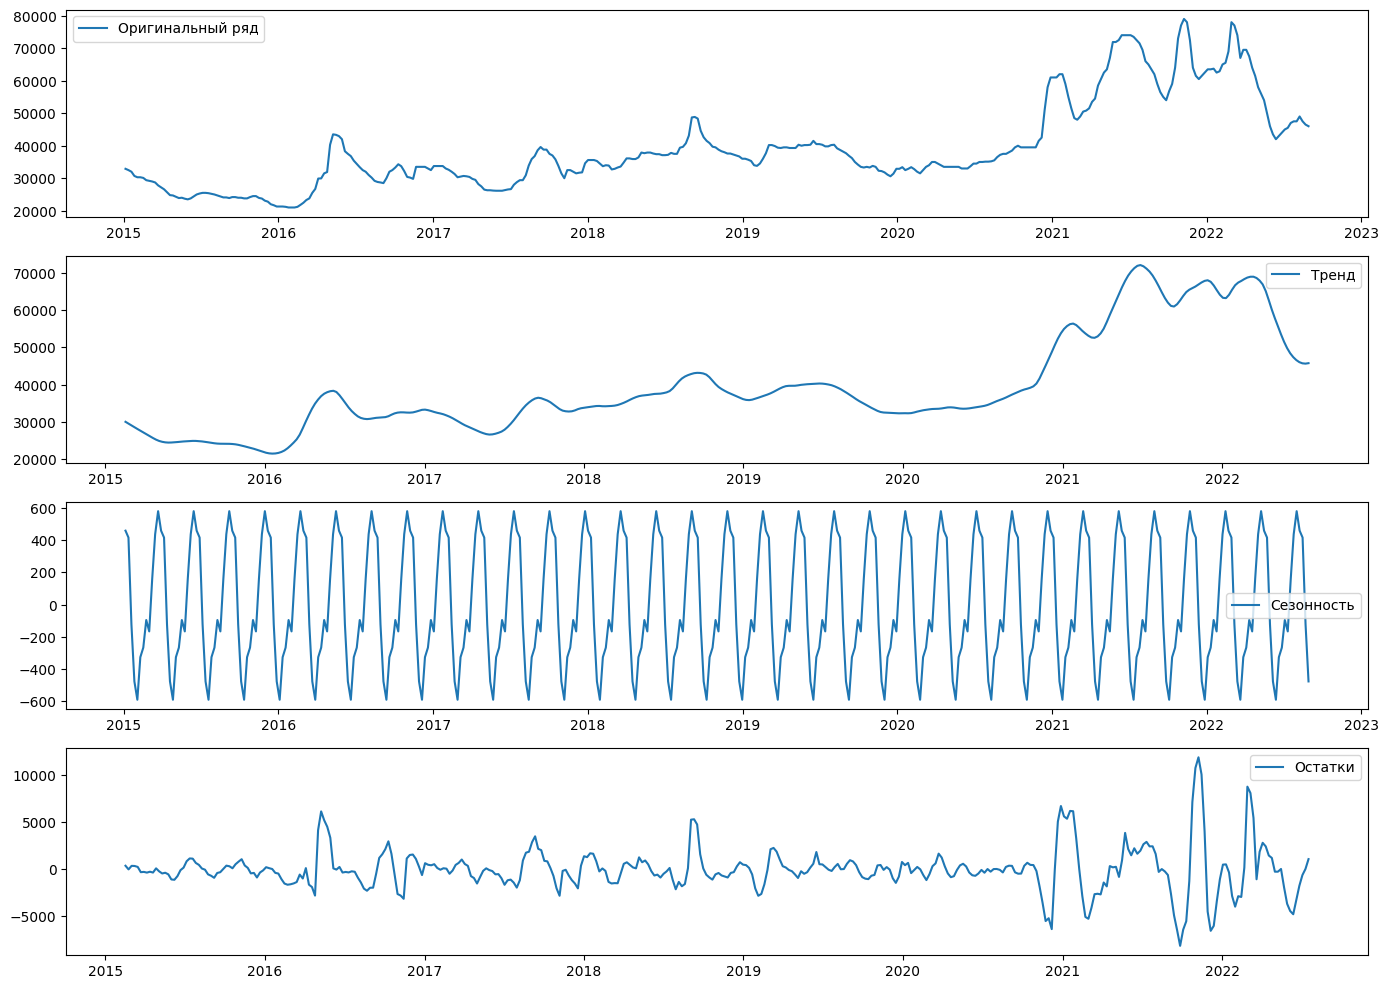

In [44]:
# Разложение на тренд, сезонность и шум
decomposition = seasonal_decompose(train_df["Цена на арматуру"], model='additive', period=12)
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(train_df["Цена на арматуру"], label='Оригинальный ряд')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Остатки')
plt.legend()
plt.tight_layout()

In [45]:
# Дифференцирование (если ряд нестационарный)
train_df["diff_1"] = train_df["Цена на арматуру"].diff().dropna()

In [46]:
# ARIMA модель
p, d, q = 2, 1, 2
train_data, val_data = train_df.iloc[:int(len(train_df)*0.9)], train_df.iloc[int(len(train_df)*0.9):]
model_arima = ARIMA(train_data["Цена на арматуру"], order=(p, d, q))
model_fit = model_arima.fit()
forecast = model_fit.forecast(steps=len(val_data))
mae_arima = mean_absolute_error(val_data["Цена на арматуру"], forecast)
mse_arima = mean_squared_error(val_data["Цена на арматуру"], forecast)
rmse_arima = np.sqrt(mse_arima)
mape_arima = np.mean(np.abs((val_data["Цена на арматуру"] - forecast) / val_data["Цена на арматуру"])) * 100
smape_arima = 100 * np.mean(2 * np.abs(forecast - val_data["Цена на арматуру"]) / (np.abs(forecast) + np.abs(val_data["Цена на арматуру"])))
print(f"ARIMA MAE: {mae_arima}, MSE: {mse_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}, SMAPE: {smape_arima}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


ARIMA MAE: 11017.969003605887, MSE: 191436820.67752478, RMSE: 13836.069553074847, MAPE: 22.209908054962806, SMAPE: 18.766605624632447


In [47]:
# LSTM подготовка данных
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(train_df["Цена на арматуру"].values.reshape(-1, 1))
X, y = [], []
seq_length = 12  # Учитываем сезонность в 12 недель
for i in range(len(data_scaled) - seq_length):
    X.append(data_scaled[i:i+seq_length])
    y.append(data_scaled[i+seq_length])
X, y = np.array(X), np.array(y)

In [48]:
# Разделение на train/test
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [49]:
# LSTM модель
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0564 - val_loss: 0.0456
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0115 - val_loss: 0.0215
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0112 - val_loss: 0.0318
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0079 - val_loss: 0.0172
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0076 - val_loss: 0.0191
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0089 - val_loss: 0.0231
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0082 - val_loss: 0.0138
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0078 - val_loss: 0.0190
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0068 - val_loss: 0.0155
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0091 - val_loss: 0.0126
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0055 - val_loss: 0.0255
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0085 - val_l

In [50]:
# Прогнозирование
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
mae_lstm = mean_absolute_error(y_test_inv, predictions)
mse_lstm = mean_squared_error(y_test_inv, predictions)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100
smape_lstm = 100 * np.mean(2 * np.abs(predictions - y_test_inv) / (np.abs(predictions) + np.abs(y_test_inv)))
print(f"LSTM MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}, MAPE: {mape_lstm}, SMAPE: {smape_lstm}")



# Выбор лучшей модели
if mae_lstm < mae_arima:
    best_model = "LSTM"
    best_mae = mae_lstm
else:
    best_model = "ARIMA"
    best_mae = mae_arima

print(f"Лучшая модель: {best_model} с MAE: {best_mae}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
LSTM MAE: 3712.61077724359, MSE: 22317900.33833039, RMSE: 4724.182504765284, MAPE: 6.592170464445099, SMAPE: 6.32140977170168
Лучшая модель: LSTM с MAE: 3712.61077724359
